# Notebook from Machine Learning Engineer Nanodegree
## Introduction and Foundations
## Project 0: Titanic Survival Exploration

In 1912, the ship RMS Titanic struck an iceberg on its maiden voyage and sank, resulting in the deaths of most of its passengers and crew. In this introductory project, we will explore a subset of the RMS Titanic passenger manifest to determine which features best predict whether someone survived or did not survive. To complete this project, you will need to implement several conditional predictions and answer the questions below. Your project submission will be evaluated based on the completion of the code and your responses to the questions.
> **Tip:** Quoted sections like this will provide helpful instructions on how to navigate and use an iPython notebook. 

Did you know that a [novella](https://en.wikipedia.org/wiki/The_Wreck_of_the_Titan:_Or,_Futility) published in 1898 had similarities with the tragedy of the Titanic in 1912? 

According to Wikipedia:

"Although the novel was written before RMS Titanic was even conceptualized, there are some uncanny similarities between the fictional and real-life versions. Like Titanic, the fictional ship sank in April in the North Atlantic, and there were not enough lifeboats for all the passengers. There are also similarities in size (800 ft (244 m) long for Titan versus 882 ft 9 in (269 m) long for the Titanic), speed, and life-saving equipment. After the Titanic's sinking, some people credited Robertson with precognition and clairvoyance, which he denied. Scholars attribute the similarities to Robertson's extensive knowledge of shipbuilding and maritime trends."

<img src="Titan_Wreck.jpg" width=240/>

## Getting Started
To begin working with the RMS Titanic passenger data, we'll first need to `import` the functionality we need, and load our data into a `pandas` DataFrame.  
Run the code cell below to load our data and display the first few entries (passengers) for examination using the `.head()` function.
> **Tip:** You can run a code cell by clicking on the cell and using the keyboard shortcut **Shift + Enter** or **Shift + Return**. Alternatively, a code cell can be executed using the **Play** button in the hotbar after selecting it. Markdown cells (text cells like this one) can be edited by double-clicking, and saved using these same shortcuts. [Markdown](http://daringfireball.net/projects/markdown/syntax) allows you to write easy-to-read plain text that can be converted to HTML.

In [73]:
import numpy as np
import pandas as pd

# RMS Titanic data visualization code 
from titanic_visualizations import survival_stats
from IPython.display import display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from time import time

# Machine learning libraries
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Load the dataset
in_file = 'data/titanic_data.csv'
full_data = pd.read_csv(in_file)

# Print the first few entries of the RMS Titanic data
display(full_data.head())

,PassengerId,Survived,Pclass,Name,Gender,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


From a sample of the RMS Titanic data, we can see the various features present for each passenger on the ship:
- **Survived**: Outcome of survival (0 = No; 1 = Yes)
- **Pclass**: Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class)
- **Name**: Name of passenger
- **Gender**: Gender of the passenger
- **Age**: Age of the passenger (Some entries contain `NaN`)
- **SibSp**: Number of siblings and spouses of the passenger aboard
- **Parch**: Number of parents and children of the passenger aboard
- **Ticket**: Ticket number of the passenger
- **Fare**: Fare paid by the passenger
- **Cabin** Cabin number of the passenger (Some entries contain `NaN`)
- **Embarked**: Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)

Since we're interested in the outcome of survival for each passenger or crew member, we can remove the **Survived** feature from this dataset and store it as its own separate variable `outcomes`. We will use these outcomes as our prediction targets.  
Run the code cell below to remove **Survived** as a feature of the dataset and store it in `outcomes`.

In [3]:
# Store the 'Survived' feature in a new variable and remove it from the dataset
outcomes = full_data['Survived']
data = full_data.drop('Survived', axis = 1)

X_train = data.drop(['Name','Ticket','Embarked','Cabin'],axis = 1)
Y_train = outcomes

# Show the new dataset with 'Survived' removed
display(data.head())

,PassengerId,Pclass,Name,Gender,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The very same sample of the RMS Titanic data now shows the **Survived** feature removed from the DataFrame. Note that `data` (the passenger data) and `outcomes` (the outcomes of survival) are now *paired*. That means for any passenger `data.loc[i]`, they have the survival outcome `outcome[i]`.

To measure the performance of our predictions, we need a metric to score our predictions against the true outcomes of survival. Since we are interested in how *accurate* our predictions are, we will calculate the proportion of passengers where our prediction of their survival is correct. Run the code cell below to create our `accuracy_score` function and test a prediction on the first five passengers.  

**Think:** *Out of the first five passengers, if we predict that all of them survived, what would you expect the accuracy of our predictions to be?*

In [4]:
def accuracy_score(truth, pred):
    """ Returns accuracy score for input truth and predictions. """
    
    # Ensure that the number of predictions matches number of outcomes
    if len(truth) == len(pred): 
        
        # Calculate and return the accuracy as a percent
        return "Predictions have an accuracy of {:.2f}%.".format((truth == pred).mean()*100)
    
    else:
        return "Number of predictions does not match number of outcomes!"
    
# Test the 'accuracy_score' function
predictions = pd.Series(np.ones(5, dtype = int))

print(accuracy_score(outcomes[:5], predictions))

Predictions have an accuracy of 60.00%.


> **Tip:** If you save an iPython Notebook, the output from running code blocks will also be saved. However, the state of your workspace will be reset once a new session is started. Make sure that you run all of the code blocks from your previous session to reestablish variables and functions before picking up where you last left off.

## Making Predictions

If we were asked to make a prediction about any passenger aboard the RMS Titanic whom we knew nothing about, then the best prediction we could make would be that they did not survive. This is because we can assume that a majority of the passengers (more than 50%) did not survive the ship sinking.  
The `predictions_0` function below will always predict that a passenger did not survive.

In [5]:
def predictions_0(data):
    """ Model with no features. Always predicts a passenger did not survive. """

    predictions = []
    for _, passenger in data.iterrows():
        
        # Predict the survival of 'passenger'
        predictions.append(0)
    
    # Return our predictions
    return pd.Series(predictions)

# Make the predictions
predictions = predictions_0(data)

### Question 1
*Using the RMS Titanic data, how accurate would a prediction be that none of the passengers survived?*  
**Hint:** Use accuracy_score function

In [6]:
# Print prediction accuracy fore Question 1
print()

**Answer:** 
Predicting that none of the passenergers survive should have an accuracy of 61.62%.

***
Let's take a look at whether the feature **Gender** has any indication of survival rates among passengers using the `survival_stats` function. This function is defined in the `titanic_visualizations.py` Python script included with this project. The first two parameters passed to the function are the RMS Titanic data and passenger survival outcomes, respectively. The third parameter indicates which feature we want to plot survival statistics across.  
Run the code cell below to plot the survival outcomes of passengers based on their sex.

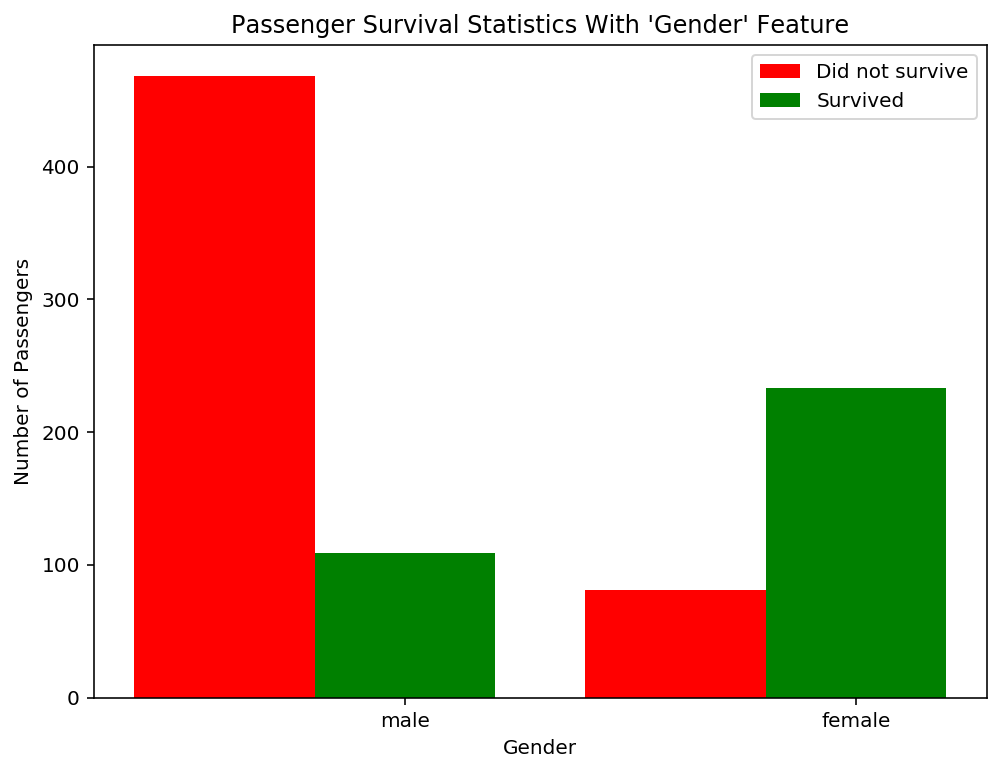

In [7]:
survival_stats(data, outcomes, 'Gender')

Examining the survival statistics, a large majority of males did not survive the ship sinking. However, a majority of females *did* survive the ship sinking. Let's build on our previous prediction: If a passenger was female, then we will predict that they survived. Otherwise, we will predict the passenger did not survive.  
Fill in the missing code below so that the function will make this prediction.  
**Hint:** You can access the values of each feature for a passenger like a dictionary. For example, `passenger['Sex']` is the sex of the passenger.

In [9]:
def predictions_1(data):
    """ Model with one feature: 
            - Predict a passenger survived if they are female. """
    
    predictions = []
    for _, passenger in data.iterrows():
        
        # Complete if statement block
        if passenger['Gender'] == 'female':
            # Fill in code here
            pass
        else:
            # Fill in code here
            pass 
    
    # Return our predictions
    return pd.Series(predictions)

# Make the predictions
predictions = predictions_1(data)

### Question 2
*How accurate would a prediction be that all female passengers survived and the remaining passengers did not survive?*  

In [10]:
# Print prediciton accuracy for Question 2 
print ()

**Answer**: Prediction should have an accuracy of 78.68%.

***
Using just the **Gender** feature for each passenger, we are able to increase the accuracy of our predictions by a significant margin. Now, let's consider using an additional feature to see if we can further improve our predictions. For example, consider all of the male passengers aboard the RMS Titanic: Can we find a subset of those passengers that had a higher rate of survival? Let's start by looking at the **Age** of each male, by again using the `survival_stats` function. This time, we'll use a fourth parameter to filter out the data so that only passengers with the **Gender** 'male' will be included.  
Run the code cell below to plot the survival outcomes of male passengers based on their age.

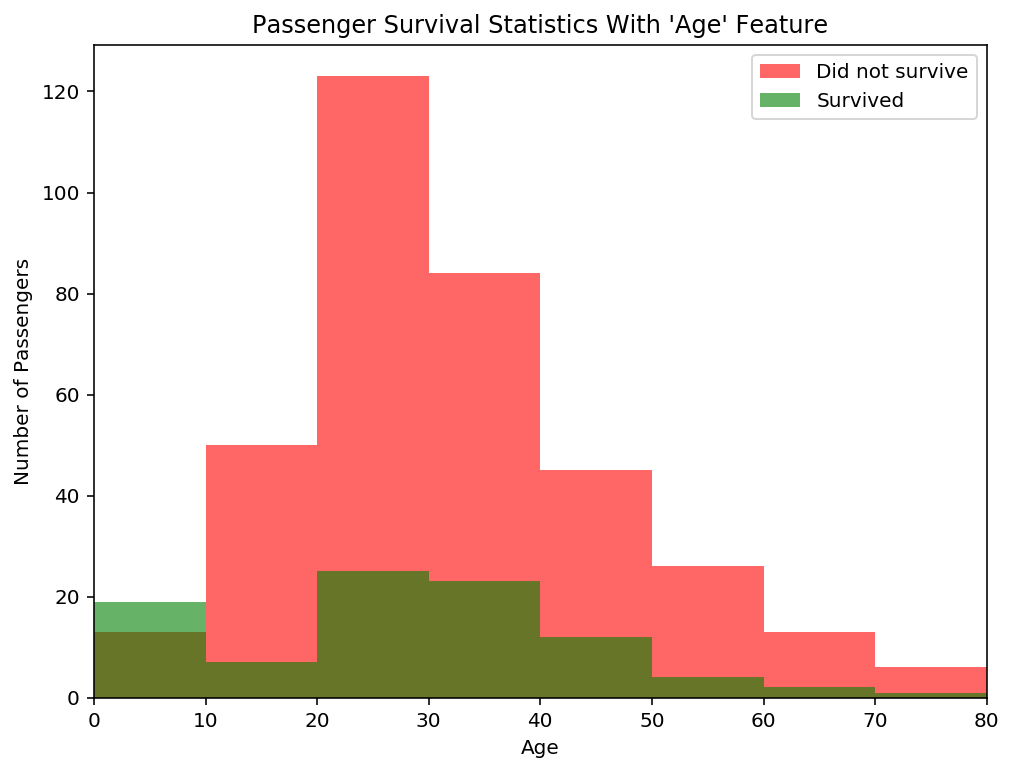

In [11]:
survival_stats(data, outcomes, 'Age', ["Gender == 'male'"])

Examining the survival statistics, the majority of males younger than 10 survived the ship sinking, whereas most males age 10 or older *did not survive* the ship sinking. Let's continue to build on our previous prediction: If a passenger was female, then we will predict they survive. If a passenger was male and younger than 10, then we will also predict they survive. Otherwise, we will predict they do not survive.  
Fill in the missing code below so that the function will make this prediction.  
**Hint:** You can start your implementation of this function using the prediction code you wrote earlier from `predictions_1`.

In [ ]:
def predictions_2(data):
    """ Model with two features: 
            - Predict a passenger survived if they are female.
            - Predict a passenger survived if they are male and younger than 10. """
    
    predictions = []
    for _, passenger in data.iterrows():
        
        # Remove the 'pass' statement below 
        # and write your prediction conditions here
        if ():
            #predictions.append()
        elif ():
            #predictions.append()
        else:
            #predictions.append()
    
    
    # Return our predictions
    return pd.Series(predictions)

# Make the predictions
predictions = predictions_2(data)

### Question 3
*How accurate would a prediction be that all female passengers and all male passengers younger than 10 survived?*  

In [49]:
# Print prediciton accuracy for Question 3
print ()

**Answer**: Prediction should have an accuracy of 79.35%.

***
Adding the feature **Age** as a condition in conjunction with **Gender** improves the accuracy by a small margin more than with simply using the feature **Gender** alone. Now it's your turn: Find a series of features and conditions to split the data on to obtain an outcome prediction accuracy of at least 80%. This may require multiple features and multiple levels of conditional statements to succeed. You can use the same feature multiple times with different conditions.   
**Pclass**, **Gender**, **Age**, **SibSp**, and **Parch** are some suggested features to try.

Use the `survival_stats` function below to to examine various survival statistics.  
**Hint:** To use mulitple filter conditions, put each condition in the list passed as the last argument. Example: `["Sex == 'male'", "Age < 18"]`

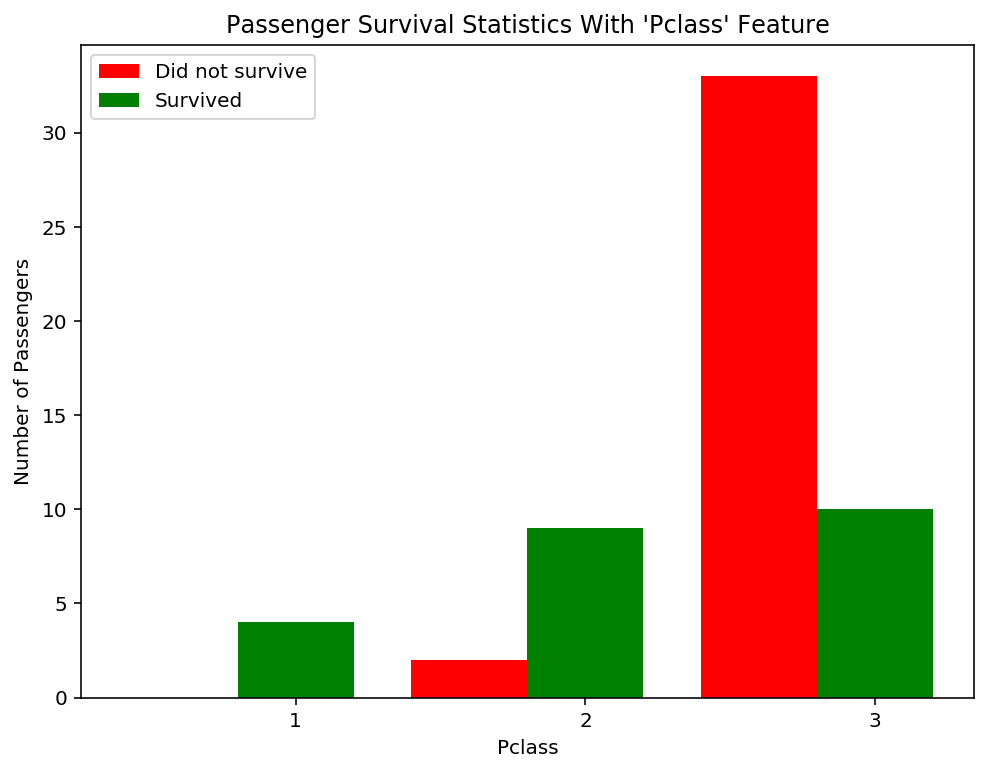

In [14]:
survival_stats(data, outcomes, 'Pclass', ["Gender == 'male'", "Age < 18"])

After exploring the survival statistics visualization, fill in the missing code below so that the function will make your prediction.  
Make sure to keep track of the various features and conditions you tried before arriving at your final prediction model.  
**Hint:** You can start your implementation of this function using the prediction code you wrote earlier from `predictions_2`.

In [64]:
def predictions_3(data):
    """ Model with multiple features. Makes a prediction with an accuracy of at least 80%. """
    
    predictions = []
    for _, passenger in data.iterrows():
        
        # Write your if statement block here
        if ():
            pass
    
    
    # Return our predictions
    return pd.Series(predictions)

# Make the predictions
predictions = predictions_3(data)


### Question 4
*Describe the steps you took to implement the final prediction model so that it got an accuracy of at least 80%. What features did you look at? Were certain features more informative than others? Which conditions did you use to split the survival outcomes in the data? How accurate are your predictions?*  

In [67]:
# Print prediction accuracy to Question 4
print()

**Answer**: Prediction should have an accuracy of at least 80%. 

## Conclusion for Manual Predictions

After several iterations of exploring and conditioning on the data, you have built a useful algorithm for predicting the survival of each passenger aboard the RMS Titanic. The technique applied in this project is a manual implementation of a simple machine learning model, the *decision tree*. A decision tree splits a set of data into smaller and smaller groups (called *nodes*), by one feature at a time. Each time a subset of the data is split, our predictions become more accurate if each of the resulting subgroups are more homogeneous (contain similar labels) than before. The advantage of having a computer do things for us is that it will be more exhaustive and more precise than our manual exploration above. [This link](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/) provides an introduction into machine learning using a decision tree.

A decision tree is just one of many models that come from *supervised learning*. In supervised learning, we attempt to use features of the data to predict or model things with objective outcome labels. That is to say, each of our data points has a known outcome value, such as a categorical, discrete label like `'Survived'`, or a numerical, continuous value like predicting the price of a house.

### Question 5
*Think of a real-world scenario where supervised learning could be applied. What would be the outcome variable that you are trying to predict? Name two features about the data used in this scenario that might be helpful for making the predictions.*  

**Answer**: 

## Implementing Machine Learning Algorithms
In this section, we will use supervised classification algorithms to see by how much we can increase prediction accuracy.

### First step is to shuffle and split data into training, validation, and test sets

In [104]:
def shuffle_split_data(X, y):
    """ Shuffles and splits data into 60% training and 40% testing subsets,
        then returns the training and testing subsets. """
    # Shuffle and split the data
    ss = ShuffleSplit(test_size=0.40)
    for train, test in ss.split(X):
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]
    
    # Return the training and testing data subsets
    return X_train, y_train, X_test, y_test

In [105]:
features = data.drop(['PassengerId','Name','Ticket','Embarked','Cabin'],axis = 1)

# Transform categorical labels into dummy variables
features = pd.get_dummies(features) ## Create dummy columns for Sex
features = features.drop(['Gender_male'], axis=1) ## Reduce redundant information
features = features.rename(columns={'Gender_female' : 'Gender'}) ## Rename sex column; 1 if female

# Still need to clean Pclass column since it is an integer classification
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit([1, 2, 3])
classes = pd.DataFrame(lb.transform(features.Pclass),
                      columns = ['First_class', 'Second_class', 'Third_class'])
features = features.reset_index(drop=True)
#y_trn = y_trn.reset_index(drop=True)
features = pd.concat([features, classes], axis=1)
features = features.drop(['Pclass', 'Third_class'], axis=1)
features = features.fillna(features.mean()['Age'])
features = normalize(features)

In [106]:
# Shuffle split data into training and validation sets
X_train, y_train, X_valid, y_valid = shuffle_split_data(features, outcomes.values)
    
# Shuffle split validation data into validation and test sets
#X_valid, y_valid, X_test, y_test = shuffle_split_data(X_valid, y_valid)

print('Size of the training set is {}.'.format(X_train.shape))
print('Size of the test set is {}.'.format(X_valid.shape))
#print('Size of the test set is {}.'.format(X_test.shape))

Size of the training set is (534, 7).
Size of the test set is (357, 7).


### Run ML algorithms
We will compare:

- K Neighbors Classifier
- Support Vector Classifier
- Random Forest Classifier


### K Neighbors Classifier

<img src="images/knn.png" width = 400>

In [107]:
knn = KNeighborsClassifier()
knn = knn.fit(X_train, y_train)
default = knn.score(X_valid, y_valid)
print('Default score for KNN is: {}'.format(default))
knn

Default score for KNN is: 0.7310924369747899


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [120]:
# Start the clock, make predictions, then stop the clock
start = time()
knn = KNeighborsClassifier()
parameters = {'n_neighbors': [3, 5, 10, 15], 
              'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],
              'leaf_size':[30, 60]}

grid = GridSearchCV(knn, parameters, refit=True, verbose=1, cv=10)
grid.fit(X_train, y_train)

end = time()
print("SVR parameter Grid Search in {:.4f} minutes.".format((end - start)/60))

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SVR parameter Grid Search in 0.0169 minutes.


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    1.0s finished
//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [121]:
best_model = knn.set_params(**grid.best_params_)
best_model.fit(X_train, y_train)
best_model.score(X_valid, y_valid)

0.7310924369747899

In [122]:
best_model

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

### Support Vector Classifier

<img src="images/svc.png" width = 400>

In [110]:
svc = SVC(gamma='auto')
svc = svc.fit(X_train, y_train)
default = svc.score(X_valid, y_valid)
print('Default score for SVC is: {}'.format(default))

Default score for SVC is: 0.6946778711484594


In [123]:
# Start the clock, make predictions, then stop the clock
start = time()

parameters = {'C': [1e-7, 1e-5, 1e-3, 1e-1], 
              'gamma': [1e-7, 1e-5, 1e-3, 1e-1],
              'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

grid = GridSearchCV(svc, parameters, refit=True, verbose=1, cv=10)
grid.fit(X_train, y_train)

end = time()
print("SVR parameter Grid Search in {:.4f} minutes.".format((end - start)/60))

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SVR parameter Grid Search in 0.0459 minutes.


[Parallel(n_jobs=1)]: Done 640 out of 640 | elapsed:    2.7s finished


In [124]:
best_model = svc.set_params(**grid.best_params_)
best_model.score(X_valid, y_valid)

0.6946778711484594

### Random Forest Classifier

<img src="images/random_forest.png" width=400>

In [117]:
clf = RandomForestClassifier(n_estimators=100)
clf = clf.fit(X_train, y_train)
score = clf.score(X_valid, y_valid)
print('Score for Random Forest is: {}'.format(score))

Score for Random Forest is: 0.773109243697479


In [92]:
# Start the clock, make predictions, then stop the clock
start = time()

parameters = {'n_estimators': np.arange(100, 1000, 200), 'max_depth': np.arange(5, 21, 5), 
              'min_samples_split': np.arange(2, 10, 2), 'min_samples_leaf': np.arange(1, 51, 10)}

grid = GridSearchCV(clf, parameters, refit=True, verbose=1, cv=10)
grid.fit(X_train, y_train)

end = time()
print("SVR parameter Grid Search in {:.4f} minutes.".format((end - start)/60))

Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SVR parameter Grid Search in 24.7424 minutes.


[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed: 24.7min finished
//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [103]:
best_model = clf.set_params(**grid.best_params_)
best_model

ValueError: Invalid parameter algorithm for estimator RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.

### Analysis
Which algorithm has the high prediction accuracy? Why?
How does the algorithm compare to the manaual analysis from above?

### Compare to code from Kaggle
Recreated code from Omar El Gabry
https://www.kaggle.com/omarelgabry/a-journey-through-titanic

In [137]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [147]:
titanic_df = full_data.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

In [148]:
# Embarked
titanic_df['Embarked'] = titanic_df['Embarked'].fillna('S')
embark_dummies_titanic = pd.get_dummies(titanic_df['Embarked'])
embark_dummies_titanic.drop(['S'], axis=1, inplace=True)
titanic_df = titanic_df.join(embark_dummies_titanic)
titanic_df.drop(['Embarked'], axis=1, inplace=True)

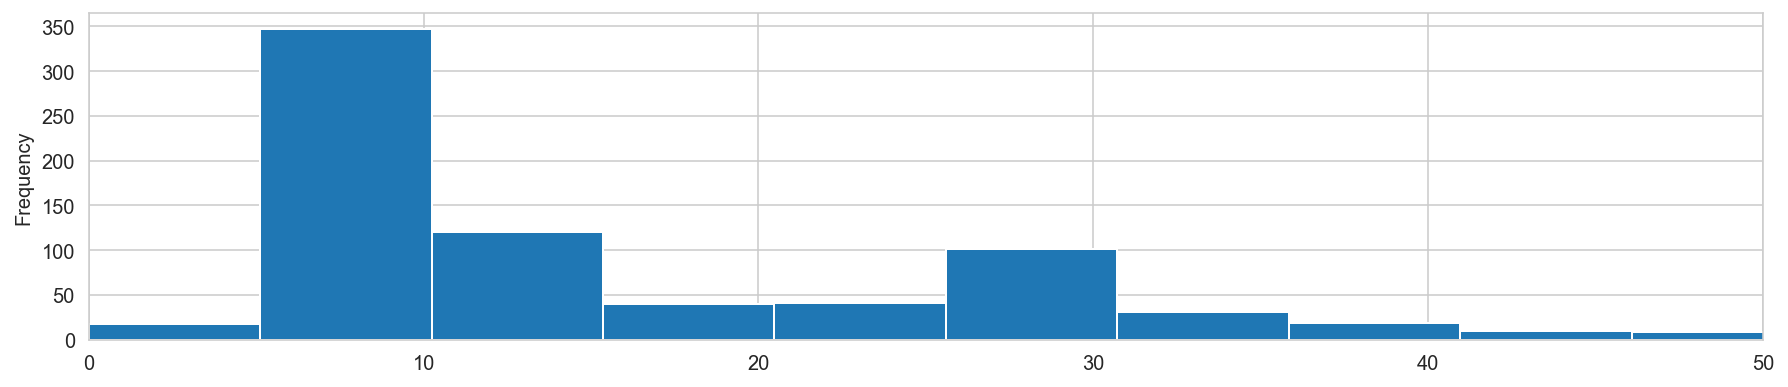

In [149]:
# Fare
titanic_df['Fare'] = titanic_df['Fare'].astype(int)
titanic_df['Fare'].plot(kind='hist', figsize=(15,3),bins=100, xlim=(0,50))
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


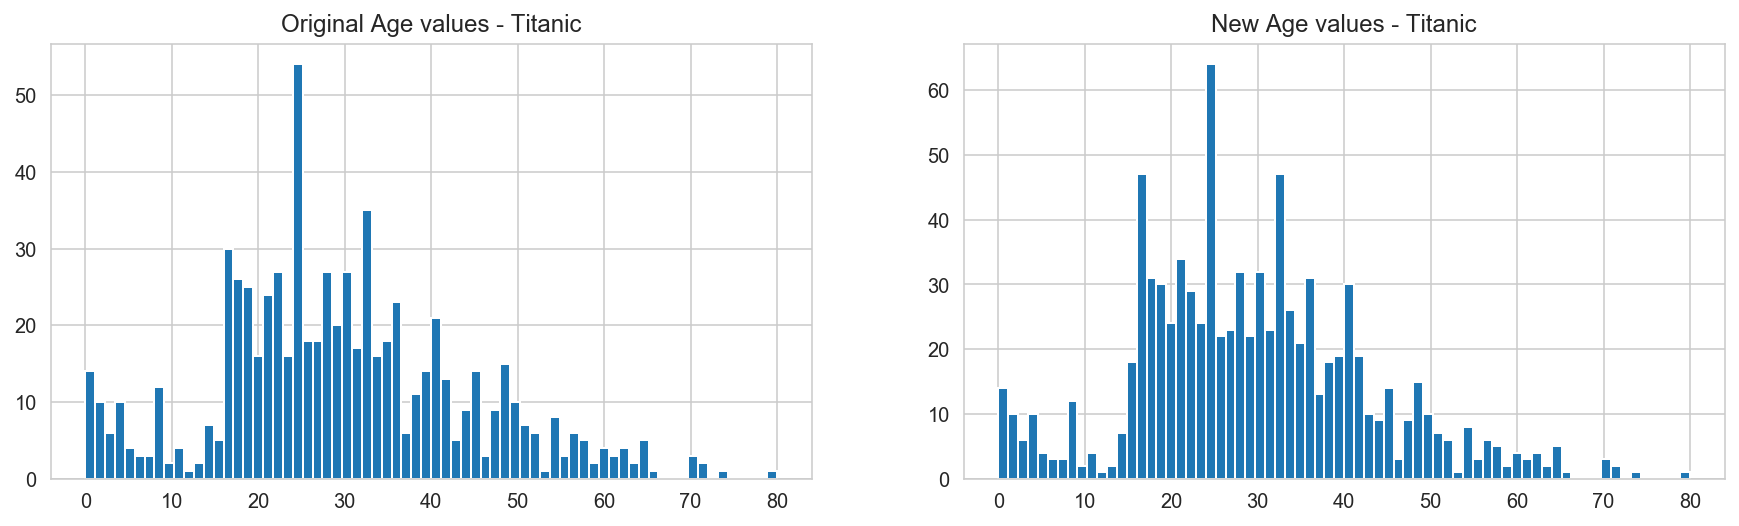

In [183]:
# Age
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Original Age values - Titanic')
axis2.set_title('New Age values - Titanic')

# get average, std, and number of NaN values in titanic_df
average_age_titanic = titanic_df['Age'].mean()
std_age_titanic = titanic_df['Age'].std()
count_nan_age_titanic = titanic_df['Age'].isnull().sum()

# generate random numbers between (mean - std) & (mean + std)
rand_1 = np.random.randint(average_age_titanic - std_age_titanic,
                          average_age_titanic + std_age_titanic,
                          size = count_nan_age_titanic)

# plot original Age values
# NOTE: drop all null values, and convert to int
titanic_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# fill NaN values in Age column with random values generated
titanic_df['Age'][np.isnan(titanic_df['Age'])] = rand_1
#titanic_df.loc[titanic_df[np.isnan(titanic_df['Age'])]] = rand_1
#titanic_df['Age'] = titanic_df['Age'].fillna(pd.Series(rand_1))

# convert from float to int
titanic_df['Age'] = titanic_df['Age'].astype(int)

# plot new Age Values
titanic_df['Age'].hist(bins=70, ax=axis2)
plt.show()

In [401]:
# Cabin
titanic_df.drop('Cabin', axis=1, inplace=True)


In [184]:
# Family
titanic_df['Family'] = titanic_df['Parch'] + titanic_df['SibSp']
titanic_df['Family'].loc[titanic_df['Family'] > 0] = 1
titanic_df['Family'].loc[titanic_df['Family'] == 0] = 0
titanic_df = titanic_df.drop(['Parch', 'SibSp'], axis=1)

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [187]:
# Sex
def get_person(passenger):
    age, sex = passenger
    return 'child' if age < 16 else sex

titanic_df['Person'] = titanic_df[['Age', 'Sex']].apply(get_person, axis=1)

titanic_df.drop(['Sex'], axis=1, inplace=True)

person_dummies_titanic = pd.get_dummies(titanic_df['Person'])
person_dummies_titanic.columns = ['Child', 'Female', 'Male']
person_dummies_titanic.drop(['Male'], axis=1, inplace=True)


titanic_df = titanic_df.join(person_dummies_titanic)

In [188]:
titanic_df.drop('Person', axis=1, inplace=True)


In [189]:
# Pclass
pclass_dummies_titanic = pd.get_dummies(titanic_df['Pclass'])
pclass_dummies_titanic.columns = ['Class_1', 'Class_2', 'Class_3']
pclass_dummies_titanic.drop('Class_3', axis=1, inplace=True)


titanic_df.drop('Pclass', axis=1, inplace=True)

titanic_df = titanic_df.join(pclass_dummies_titanic)


In [195]:
X_TRN = titanic_df.drop(['Survived', 'Cabin'], axis=1)
Y_TRN = titanic_df['Survived']
X_TRN.head()

,Age,Fare,C,Q,Family,Child,Female,Class_1,Class_2
0,22,7,0,0,1,0,0,0,0
1,38,71,1,0,1,0,1,1,0
2,26,7,0,0,0,0,1,0,0
3,35,53,0,0,1,0,1,1,0
4,35,8,0,0,0,0,0,0,0


In [197]:
logreg = LogisticRegression()
logreg.fit(X_TRN, Y_TRN)
logreg.score(X_TRN, Y_TRN)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8047138047138047

In [198]:
svc = SVC()
svc.fit(X_TRN, Y_TRN)
svc.score(X_TRN, Y_TRN)

//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8608305274971941

In [199]:
frst = RandomForestClassifier(n_estimators=100)
frst.fit(X_TRN, Y_TRN)
frst.score(X_TRN, Y_TRN)

0.9607182940516273

In [200]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_TRN, Y_TRN)
knn.score(X_TRN, Y_TRN)

0.8316498316498316

In [201]:
gauss = GaussianNB()
gauss.fit(X_TRN, Y_TRN)
gauss.score(X_TRN, Y_TRN)

0.7586980920314254

### Key differences
Main differences between Omar and my approach are:

- Omar does drop missing values. Instead he randomly generated values using mean and stadard deviation. I found this to be an elegant approach to simulating relevant data that did not distort the signature of the original data set.
- Omar separates out children and combines the siblings and parental columnts into one.
- My resulting Random Forest and SVC models slight outperform his while his KNN model slightly beats mine.